In [1]:
import numpy as np
import h5py 
from matplotlib import pyplot as plt

In [2]:
folder = "C:/Users/tracy/OneDrive - Imperial College London/PhD/Code_md-ae/MD_2__2022_02_02__16_51_24/"

filename = folder + 'results.h5'
file = h5py.File(filename,'r')
u_train = np.array(file.get('u_train')) # fluctuating velocity if REMOVE_MEAN is true
y_train = np.array(file.get('y_train'))
u_test = np.array(file.get('u_test')) # fluctuating velocity if REMOVE_MEAN is true
y_test = np.array(file.get('y_test'))
u_avg = np.array(file.get('u_avg'))
latent_train = np.array(file.get('latent_train'))
latent_test = np.array(file.get('latent_test'))
modes_train = np.array(file.get('modes_train'))
modes_test = np.array(file.get('modes_test')) #(modes,snapshots,Nx,Ny,Nu)
file.close()

filename = folder + 'Model_param.h5'
file = h5py.File(filename,'r')
lmb = file.get('lmb')[()]#1e-05 #regulariser
drop_rate = file.get('drop_rate')[()]
features_layers = np.array(file.get('features_layers')).tolist()
latent_dim = file.get('latent_dim')[()]
act_fct = file.get('act_fct')[()].decode()
resize_meth = file.get('resize_meth')[()].decode()
filter_window= np.array(file.get('filter_window')).tolist()
batch_norm = file.get('batch_norm')[()]
REMOVE_MEAN = file.get('REMOVE_MEAN')[()]
file.close()

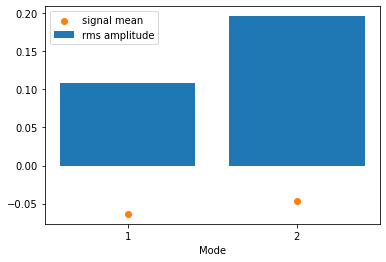

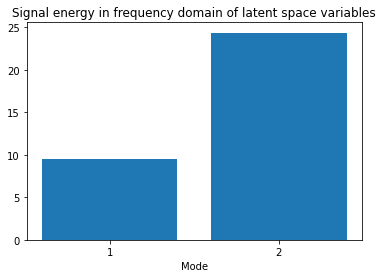

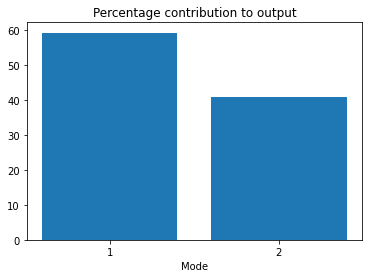

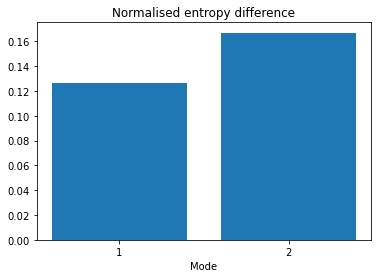

In [3]:
import autoencoder_modes_selection as ranking

#========================= RMS amplitude of latent variable =====================
amp_rms,m = ranking.rms_amplitude(latent_test)
plt.figure()
plt.bar(np.arange(latent_dim)+1,amp_rms,label='rms amplitude')
plt.scatter(np.arange(latent_dim)+1,m,label='signal mean')
plt.xticks(np.arange(latent_dim)+1)
plt.legend()
plt.xlabel("Mode")
plt.show()

#============================ energy spectrum of signal ==========================
signal_energy = ranking.energy_freq(latent_test)
plt.figure()
plt.bar(np.arange(latent_dim)+1,signal_energy)
plt.xticks(np.arange(latent_dim)+1)
plt.xlabel("Mode")
plt.title("Signal energy in frequency domain of latent space variables")
plt.show()

#============================ mse loss ============================================
per_mode = ranking.percent_output(modes_test,y_test)
plt.figure()
plt.bar(np.arange(latent_dim)+1,per_mode*100)
plt.xticks(np.arange(latent_dim)+1)
plt.xlabel("Mode")
plt.title("Percentage contribution to output")
plt.show()

#=============================== NED ==============================================
NED = ranking.NED(latent_test,20)
plt.figure()
plt.bar(np.arange(latent_dim)+1,NED)
plt.xticks(np.arange(latent_dim)+1)
plt.xlabel("Mode")
plt.title("Normalised entropy difference")
plt.show()